In [1]:
# ✅ 시간 중요도 공통점 분석 (3가지 방법)

import os
import numpy as np
import matplotlib.pyplot as plt
import joblib
import copy
from sklearn.base import BaseEstimator, TransformerMixin
from sktime.transformations.panel.rocket import MiniRocketMultivariate

In [2]:
# ✅ MiniRocketWrapper
class MiniRocketWrapper(BaseEstimator, TransformerMixin):
    def __init__(self, num_kernels=1000):
        self.num_kernels = num_kernels
        self.transformer = MiniRocketMultivariate(num_kernels=self.num_kernels)

    def fit(self, X, y=None):
        return self.transformer.fit(X, y)

    def transform(self, X):
        return self.transformer.transform(X)

In [4]:
# ✅ 중요도 계산 함수
def compute_temporal_importance(X_sample, model, window_size=30):
    X_sample = X_sample[None, :, :]  # (1, T, C)
    original_prob = model.predict_proba(X_sample)[0][1]
    T = X_sample.shape[1]
    importance = np.zeros(T)
    for start in range(0, T, window_size):
        end = min(start + window_size, T)
        X_masked = copy.deepcopy(X_sample)
        X_masked[0, start:end, :] = 0
        prob = model.predict_proba(X_masked)[0][1]
        importance[start:end] = abs(original_prob - prob)
    return importance

# ✅ 데이터 및 모델 로드
BASE_DIR = "C:/BitaminDirectory/Sleep_Anomaly_Detection"
split_dir = os.path.join(BASE_DIR, "Database", "processed", "split")
model_path = os.path.join(BASE_DIR, "trained_models", "minirocket_rf_pipeline.pkl")

model = joblib.load(model_path)

X_val = np.concatenate([
    np.load(os.path.join(split_dir, "X_val_0.npy"), mmap_mode="r"),
    np.load(os.path.join(split_dir, "X_val_1.npy"), mmap_mode="r")
])
X_val = np.transpose(X_val, (0, 2, 1))  # (N, T, C)



In [5]:
# ✅ 분석 대상 샘플 선정 (상위 예측 확률 기준)
y_val = np.concatenate([
    np.load(os.path.join(split_dir, "y_val_0.npy"), mmap_mode="r"),
    np.load(os.path.join(split_dir, "y_val_1.npy"), mmap_mode="r")
])

probs = model.predict_proba(X_val)[:, 1]
selected_idxs = np.argsort(probs)[-10:]  # 상위 10개


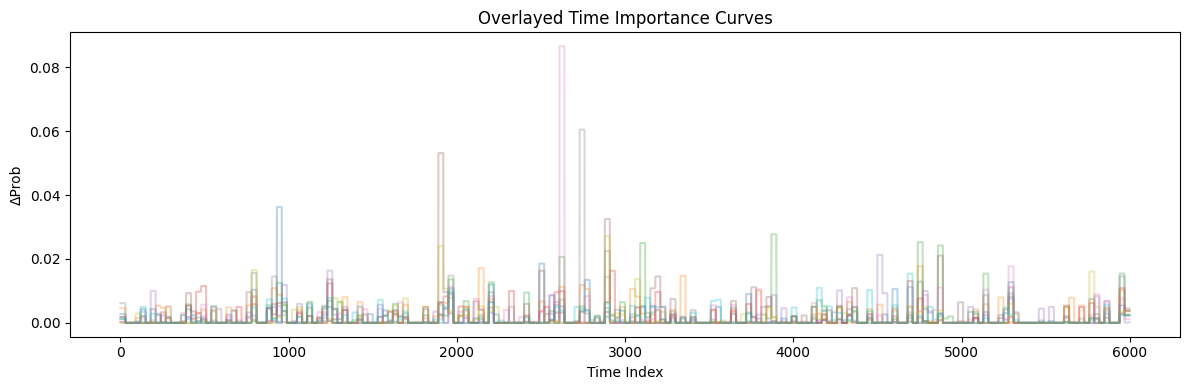

In [6]:
# ✅ (1) Overlay Plot
plt.figure(figsize=(12, 4))
for idx in selected_idxs:
    imp = compute_temporal_importance(X_val[idx], model)
    plt.plot(imp, alpha=0.3, label=f"#{idx}")
plt.title("Overlayed Time Importance Curves")
plt.xlabel("Time Index")
plt.ylabel("ΔProb")
plt.tight_layout()
plt.show()


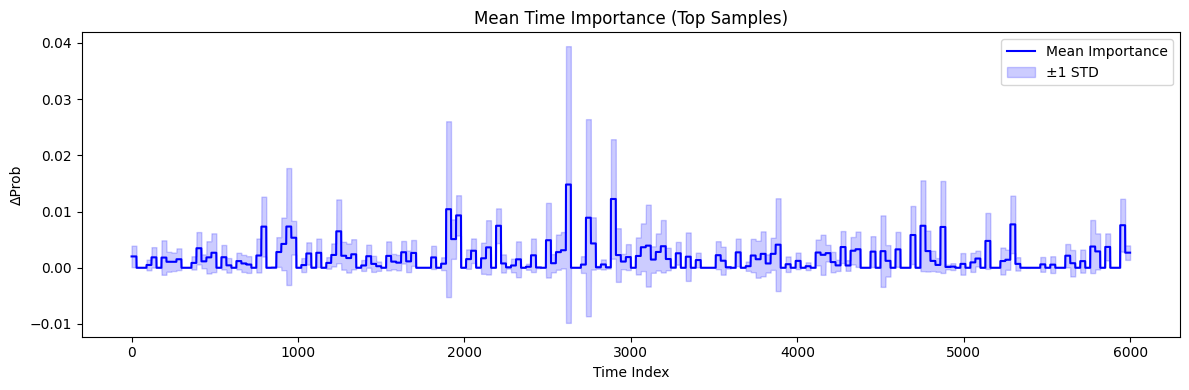

In [7]:
# ✅ (2) Mean Importance + Std 영역
importances = [compute_temporal_importance(X_val[idx], model) for idx in selected_idxs]
avg_importance = np.mean(importances, axis=0)
std_importance = np.std(importances, axis=0)

plt.figure(figsize=(12, 4))
plt.plot(avg_importance, label="Mean Importance", color="blue")
plt.fill_between(np.arange(len(avg_importance)),
                 avg_importance - std_importance,
                 avg_importance + std_importance,
                 color='blue', alpha=0.2, label="±1 STD")
plt.title("Mean Time Importance (Top Samples)")
plt.xlabel("Time Index")
plt.ylabel("ΔProb")
plt.legend()
plt.tight_layout()
plt.show()

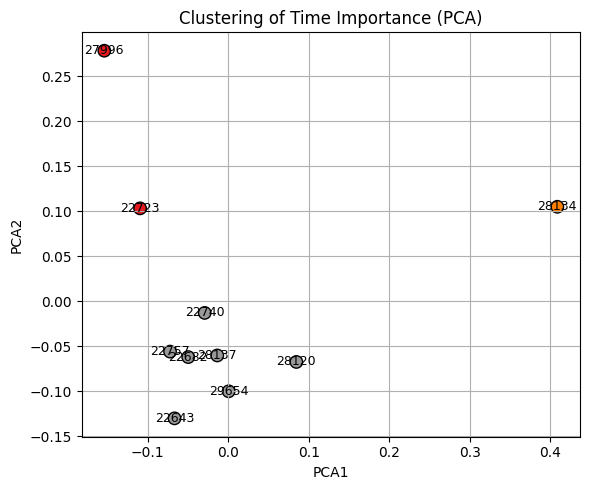

In [8]:
# ✅ (3) Clustering 시각화 (PCA 기준)
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

X_imp = np.array(importances)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_imp)

kmeans = KMeans(n_clusters=3, random_state=42).fit(X_pca)
labels = kmeans.labels_

plt.figure(figsize=(6, 5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='Set1', s=80, edgecolors='k')
for i, idx in enumerate(selected_idxs):
    plt.text(X_pca[i, 0], X_pca[i, 1], str(idx), fontsize=9, ha='center', va='center')
plt.title("Clustering of Time Importance (PCA)")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.grid(True)
plt.tight_layout()
plt.show()
